# Creating a frequency finder auto-encoder

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
import tensorflow.keras as keras
from tensorflow.keras import layers
import umap
from babyplots import Babyplot
#import hdbscan
from matplotlib import pyplot
from models import *
from converters import *
from helpers import *
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

2021-10-06 14:29:33.831841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-06 14:29:33.831857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext autoreload
%autoreload 2

## Get drive path 

In [3]:
drive_path = find_drive_path()
drive_path

UnboundLocalError: local variable 'path' referenced before assignment

## Load Data from drive

In [4]:
try:
    data = pd.read_pickle(f"{drive_path}/Data/Inputs/Synthetisch/Syn_tot.pkl")
except:
    data = pd.read_pickle("../../Data/Syn01_02.pkl")
data.head()

,IID,Pheno,Geno,State
0,0pop1,0,"[2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1healthy
1,1pop1,1,"[0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...",pop1sick
2,2pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",pop1sick
3,3pop1,1,"[2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, ...",pop1sick
4,4pop1,1,"[2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, ...",pop1sick


In [5]:
data.tail()

,IID,Pheno,Geno,State
1995,995pop2,1,"[0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, ...",pop2sick
1996,996pop2,0,"[1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, ...",pop2healthy
1997,997pop2,0,"[0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, ...",pop2healthy
1998,998pop2,0,"[2, 2, 0, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, ...",pop2healthy
1999,999pop2,0,"[0, 0, 0, 2, 2, 0, 1, 1, 2, 1, 0, 2, 1, 1, 0, ...",pop2healthy


## Preprocessing data into tensors 

### Keeping only the minor alleles as 1

In [18]:
X = only_minor(data["Geno"])
y = data["Pheno"]
y

0       0
1       1
2       1
3       1
4       1
       ..
1995    1
1996    0
1997    0
1998    0
1999    0
Name: Pheno, Length: 2000, dtype: int64

### Train test split

In [19]:
split = splitter([X,y],0.1)
[X_train, X_test, y_train, y_test] = tensor_converter(split)
X = tensor_converter(X)
y = tensor_converter(y)
X = tf.stack(X, axis = 0)
y = tf.stack(y, axis = 0)

In [20]:
y

<tf.Tensor: shape=(2000,), dtype=float32, numpy=array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)>

## Loading hyper-parameters

In [49]:
BATCH_SIZE = 64
WEIGHT_DECAY = 0.001
PRUNING = 0.5
LEARNING_RATE = 0.01
first_layer = 200
second_layer = 1

In [50]:
input_len = int(tf.shape(X_train)[1])
AE = AutoEncoder(input_len, first_layer, second_layer)
AE.build((None, input_len))

In [51]:
output_test = AE(X)

In [ ]:
checkpoint_path = "../../Data/"
es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)
AE.save_weights(checkpoint_path.format(epoch=0))
AE.compile(
    optimizer = keras.optimizers.Adam(LEARNING_RATE),
    loss = "BinaryCrossentropy",
    metrics = ["BinaryAccuracy"])

autoencoder_model = AE.fit(X_train, 
          X_train, 
          validation_data=(X_test, X_test),
          epochs = 150,
          callbacks=[es,cp_callback],
          verbose = 1)

Epoch 1/150








55/57 [===========================>..] - ETA: 0s - loss: 8.0030 - binary_accuracy: 0.4693



57/57 [==============================] - 2s 24ms/step - loss: 8.0138 - binary_accuracy: 0.4687 - val_loss: 8.4935 - val_binary_accuracy: 0.4439
Epoch 2/150
57/57 [==============================] - 1s 22ms/step - loss: 8.6460 - binary_accuracy: 0.4337 - val_loss: 8.7859 - val_binary_accuracy: 0.4247
Epoch 3/150
57/57 [==============================] - 1s 23ms/step - loss: 8.8470 - binary_accuracy: 0.4205 - val_loss: 8.8820 - val_binary_accuracy: 0.4180
Epoch 4/150
57/57 [==============================] - 1s 23ms/step - loss: 8.1809 - binary_accuracy: 0.4613 - val_loss: 7.0258 - val_binary_accuracy: 0.5397
Epoch 5/150
57/57 [==============================] - 1s 23ms/step - loss: 6.4310 - binary_accuracy: 0.5796 - val_loss: 6.3075 - val_binary_accuracy: 0.5879
Epoch 6/150
34/57 [================>.............] - ETA: 0s - loss: 6.3133 - binary_accuracy: 0.5876
Epoch 00006: savi

In [20]:
from tensorflow_probability.python import layers as tfpl

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.8.12/envs/ctg/lib/python3.8/site-packages/matplotlib/pyplot.py'>

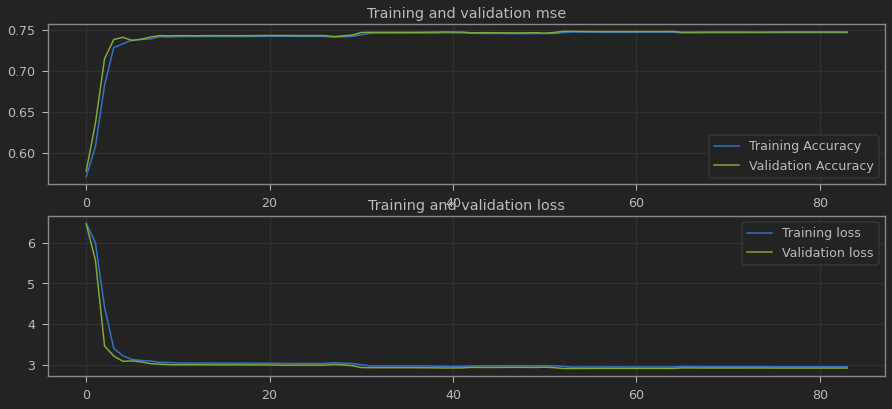

In [26]:
metrics_viewer(autoencoder_model)

In [29]:
dir(AE(X))

['OVERLOADABLE_OPERATORS',
 '_USE_EQUALITY',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__complex__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',


In [40]:
test = AE(X)

In [48]:
AE.layers[0](X)

<tf.Tensor: shape=(2000, 46), dtype=float32, numpy=
array([[-1.10888420e+02, -2.67575989e+02,  3.29356567e+02, ...,
        -2.94464203e+02,  2.14401428e+02, -3.22692413e+01],
       [-1.14721085e+02, -2.77587372e+02,  3.42751404e+02, ...,
        -3.06687531e+02,  2.23036026e+02, -3.28784981e+01],
       [-1.09045410e+02, -2.65620911e+02,  3.27112000e+02, ...,
        -2.93951324e+02,  2.12526001e+02, -2.95888920e+01],
       ...,
       [-5.02031296e-02,  3.57611179e-02, -9.16775912e-02, ...,
        -3.48195620e-02,  1.25974193e-01, -5.92759438e-02],
       [-5.02031296e-02,  3.57611179e-02, -9.16775912e-02, ...,
        -3.48195620e-02,  1.25974193e-01, -5.92759438e-02],
       [-5.02031296e-02,  3.57611179e-02, -9.16775912e-02, ...,
        -3.48195620e-02,  1.25974193e-01, -5.92759438e-02]], dtype=float32)>